<a href="https://colab.research.google.com/github/deokwoo-han/abc/blob/master/0930_%5BProject%5D_EDA_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Objective
* [Reference](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart)
* Reconstructed by JaeHong Jeong
>- 2021/09/30

* The goal of the competition is to predict which products will be in a user's next order. 
>- The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline
%config InlineBackend.figure_config = 'retina'

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pwd cd

/content


In [ ]:
file_path = './drive/MyDrive/# ML Project 시나브로/data'
order_products_train_df = pd.read_csv(file_path + "/order_products__train.csv")
order_products_prior_df = pd.read_csv(file_path + "/order_products__prior.csv")
orders_df = pd.read_csv(file_path + "/orders.csv")
products_df = pd.read_csv(file_path + "/products.csv")
aisles_df = pd.read_csv(file_path + "/aisles.csv")
departments_df = pd.read_csv(file_path + "/departments.csv")

### 1.1. orders.csv

In [ ]:
orders_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [ ]:
orders_df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

* orders.csv
>- 'order_id': the ID of the order
>- 'user_id': the ID of the user
>- 'eval_set': which tells us as to which of the three datasets (prior, train or test) the given row goes to.
>- 'order_number': The order number made by the customer
>- 'order_dow': The day of the week (Sun ~ Sat)
>- 'order_hour_of_day' (주문시간)
>- 'days_since_prior_order': The number of days since last order (첫주문인 경우 NaN값)

#### a) eval_set 이란 무엇일까?
* Let us first get the count of rows in each of the three sets.
>- prior, train, test sets
```
prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64
```

In [ ]:
cnt_srs = orders_df.eval_set.value_counts()
cnt_srs

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


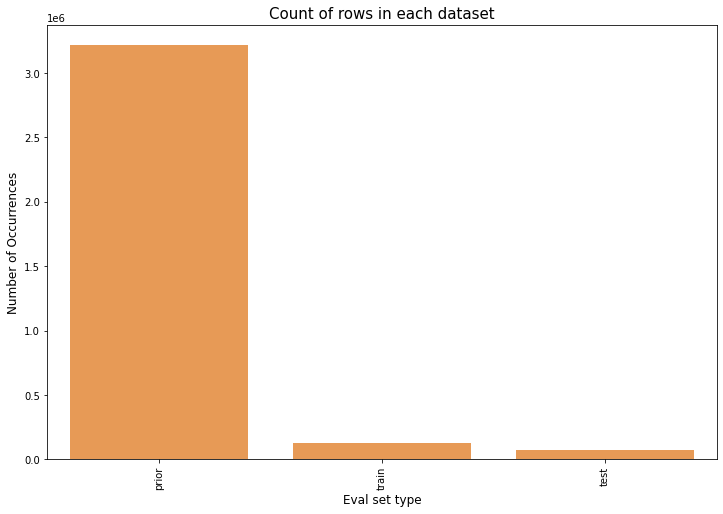

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

#### b) eval_set별로, user_id(회원 수)는 몇 명일까?
* orders.csv의 eval_set별 user_id의 unique 개수 반환
>- 206,209 회원 in total. 
>- 그 중에서, Train set에는 최근 구매한 131,209 회원이 주어짐
>- Test set의 75,000 회원의 재구매 여부를 예측해야함
```
eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64
```

In [ ]:
cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(lambda x : len(np.unique(x)))
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

#### c) user_id 별로, 몇번이나 이용했을까?
* Now let us validate the claim that 4 to 100 orders of a customer are given. 

In [ ]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5
...,...,...
206204,206205,4
206205,206206,68
206206,206207,17
206207,206208,50


In [ ]:
cnt_srs = cnt_srs.order_number.value_counts()
cnt_srs

4     23986
5     19590
6     16165
7     13850
8     11700
      ...  
94       57
91       56
97       54
98       50
99       47
Name: order_number, Length: 97, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


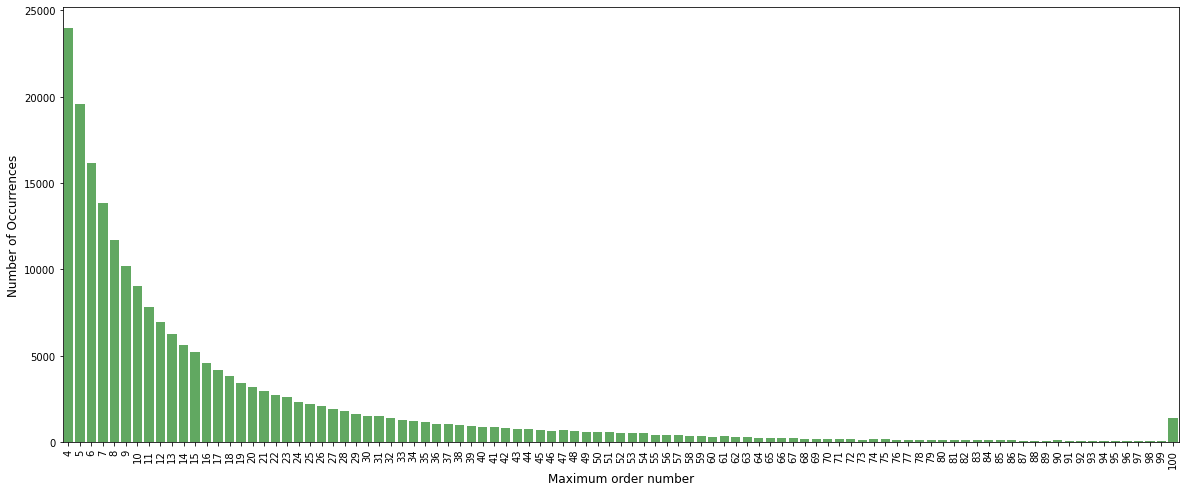

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

* 최소 4번 주문한 고객부터, 최대 100번 주문한 고객까지 분포해있다.

#### d) day_of_the_week (요일별) 주문 패턴은 어떨까?
* 
>- order_dow
>- 0: Saturday to 6: Friday
```
array([0, 1, 2, 3, 4, 5, 6])
```

In [ ]:
np.unique(orders_df['order_dow'])

array([0, 1, 2, 3, 4, 5, 6])

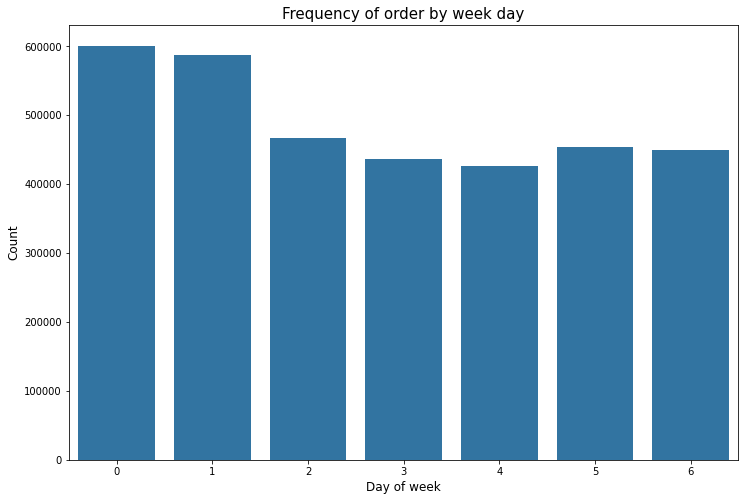

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

* 토, 일 ( [0, 1])은 주문량이 높고, 수요일(4)가 제일 주문량이 적었다.

#### e) time of the day(시간대별) 주문 패턴은 어떨까?

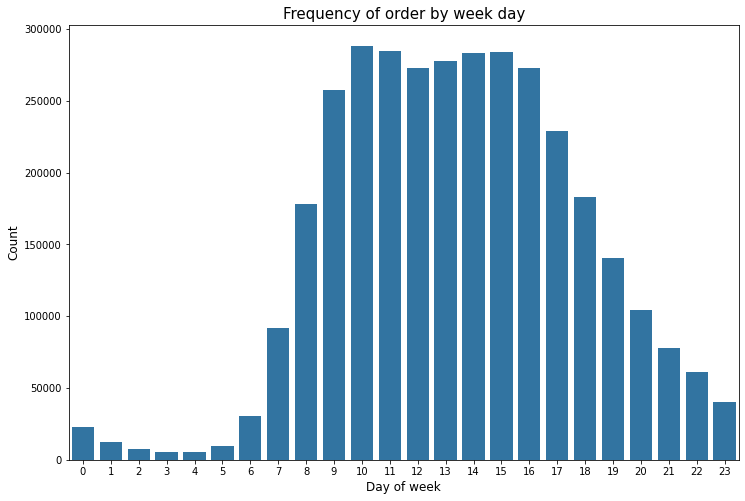

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

* 대부분의 주문이 daytime(9시~16시)에 모여있다.

#### f) the day of week & the hour of day (요일 + 시간대별 결합하면 어떨까?)

In [ ]:
grouped_df = orders_df.groupby(['order_dow', 'order_hour_of_day'])['order_number'].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')
grouped_df

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
0,3936,2398,1409,963,813,1168,3329,12410,28108,40798,48465,51035,51443,53849,54552,53954,49463,39753,29572,22654,18277,14423,11246,6887
1,3674,1830,1105,748,809,1607,5370,16571,34116,51908,55671,51584,47079,46728,46764,46403,44761,36792,28977,22145,16281,11943,8992,5620
2,3059,1572,943,719,744,1399,4758,13245,24635,36314,39230,38128,35780,36650,37173,37469,37541,32151,26470,20084,15039,10653,8146,5358
3,2952,1495,953,654,719,1355,4562,12396,22553,32312,36040,35215,33455,34161,34773,35990,35273,30368,25001,19249,13795,10278,8242,5181
4,2642,1512,899,686,730,1330,4401,12493,21814,31409,35034,33857,32249,32751,33625,34222,34093,29378,24425,19350,14186,10796,8812,5645
5,3189,1672,1016,841,910,1574,4866,13434,24015,34232,38313,37915,35714,36296,37407,37508,35860,29955,24310,18741,13322,9515,7498,5265
6,3306,1919,1214,863,802,1136,3243,11319,22960,30839,35665,36994,37121,37564,38748,38093,35562,30398,24157,18346,13392,10501,8532,6087


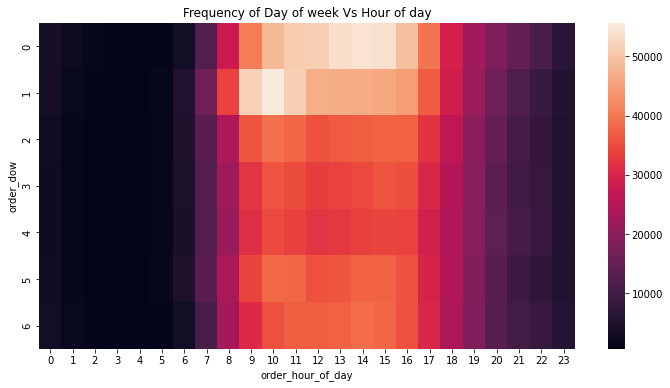

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

* Seems Satuday evenings and Sunday mornings are the prime time for orders.

#### g) time interval between the orders (주문의 간격은 어떻게 될까?)

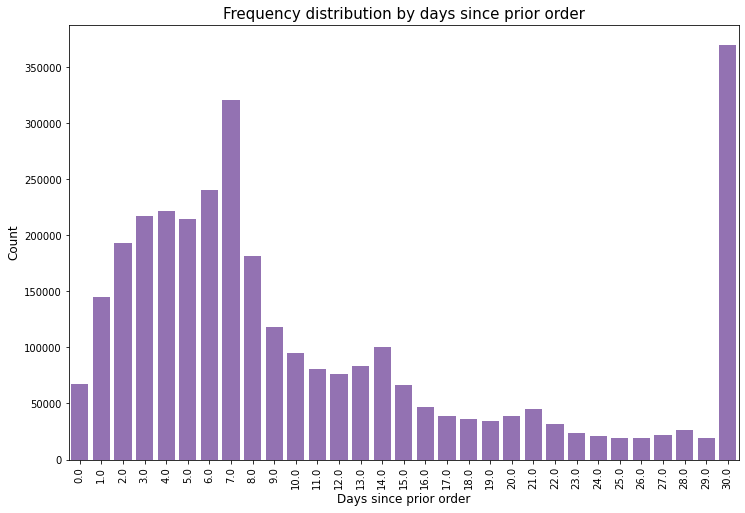

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[4])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

* 7일에 한번, 
* 30일에 한번 (peak at 30 days). 
* We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).

### 1.2. order_products_train & order_products_prior
* The columns present in ```order_products_train``` and ```order_products_prior``` are same. 
>- Then what is the difference between these files?
* In this dataset, we need to predict the products that will be re-ordered.
* All the prior order informations of the customer are present in order_products_prior file.
* ```order_products_*.csv``` has more detailed information about the products that been bought in the given order along with the re-ordered status.

In [ ]:
order_products_prior_df

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [ ]:
order_products_train_df

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [ ]:
print(order_products_prior_df.columns, order_products_train_df.columns, sep='\n')

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')
Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')


#### a) Reorder Percentage 재주문율 확인하기

* 목표 변수인 re-orders를 확인하기 위해, re-order percentage 재주문율을 in prior set and train set에서 확인하기

In [ ]:
# percentage of re-orders in prior set 
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

In [ ]:
# percentage of re-orders in train set #
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

* 평균적으로 약 59%의 상품들이 재주문이 되었다.


#### b) 재주문되지 않은 상품 살펴보기

* 약 59%의 상품이 재주문되었지만, 장바구니 제품 중 하나라도 재주문되지 않은 상품이 있을 수 있다. Let us check that now.

In [ ]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df['reordered'][grouped_df["reordered"]>1] = 1
grouped_df

,order_id,reordered
0,2,1
1,3,1
2,4,1
3,5,1
4,6,0
...,...,...
3214869,3421079,0
3214870,3421080,1
3214871,3421081,0
3214872,3421082,1


In [ ]:
grouped_df['reordered'].value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [ ]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df.reordered[grouped_df["reordered"]>1] = 1
grouped_df['reordered'].value_counts() / grouped_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

* 재주문되지 않은 상품 분석하기
>- prior set에는 약 12%가 no re-ordered items 인 반면에
>- train set에는 약 6.5%가 no re-ordered items 이었다.

|reordered | order_products_prior.csv | order_products_train.csv |
:---: | :---: | :---:
1 | 0.879151 | 0.93444
0 | 0.120849 | 0.06556


#### c) 각 주문별로 상품이 얼마나 구매되었을까?
* Now let us see the number of products bought in each order.

In [ ]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df["add_to_cart_order"].value_counts()
cnt_srs

5     8895
6     8708
7     8541
4     8218
3     8033
      ... 
68       2
66       2
67       1
75       1
77       1
Name: add_to_cart_order, Length: 75, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


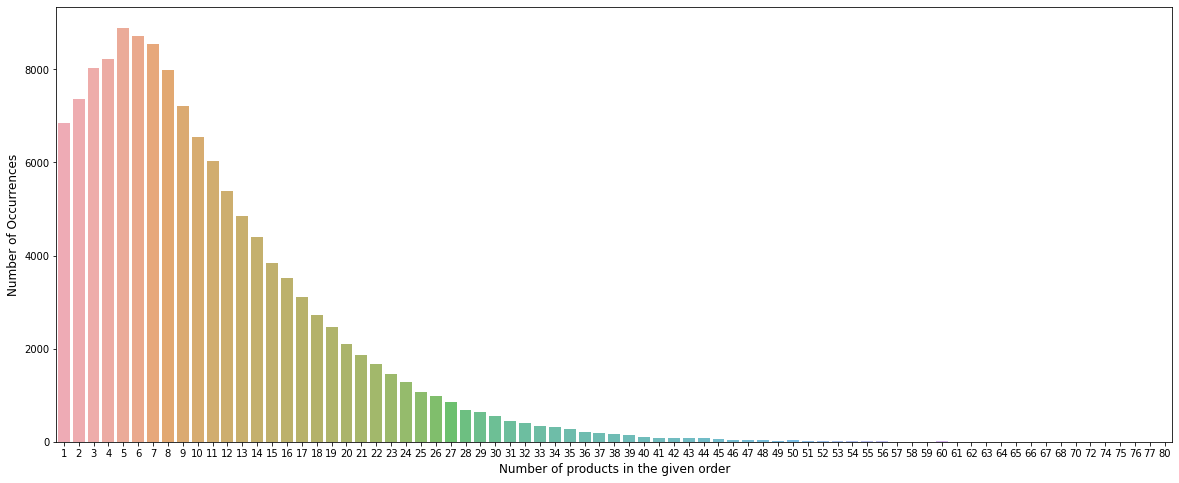

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.show()

* 오른쪽 꼬리 분포 (A right tailed distribution) with the maximum value at 5

### 1.3. 기타 파일들 (products.csv, aisles.csv, departments.csv)
* Before we explore the product details, let us look at the other three files as well.



#### a) products.csv
* This dataset gives information on the products such as product name, product ID, aisle and departments, which were sold to the customer.
* Product ID 
>- Labels the ID of the products purchased by customers
* Product Name
>- Denotes the product name purchased by the customer
* Aisle ID
>- Labels the ID of the aisles
* Departments ID
>- Labels the ID of the departments

In [ ]:
products_df

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


#### b) aisles.csv
* This dataset provides information on the aisles such as aisle ID and aisle names, through which the products were organized.
* Aisle ID 
>- Labels the ID of the aisles
* Aisle name
>- Mentions the aisle name in the retail stores



In [ ]:
aisles_df

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


#### c) departments.csv

* This dataset provides information on the departments such as department names and department Id.
* Department ID
>- Labels the ID of the departments
* Department name
>- Mentions the department name in the retail stores


In [ ]:
departments_df

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


### 1.4. order_products_prior.csv에 기타 파일 Merge하기
>- Now let us merge these product details with the order_prior details.

In [ ]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [ ]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(30)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


* 상위 30위 품목을 살펴보니, 대부분은 organic products 이다.
>- Also majority of them are fruits. 


#### a) aisles 분포
* Now let us look at the important aisles.

In [ ]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(30)
cnt_srs

fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
refrigerated                      575881
frozen produce                    522654
ice cream ice                     498425
crackers                          458838
energy granola bars               456386
eggs                              452134
lunch meat                        395130
frozen meals                      390299
baby food formula                 382456
fresh herbs                       377741
cereal                            377586
soft drinks                       357537
fresh dips tapenades              355685
soup broth bouillon               346464
juice nectars   

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


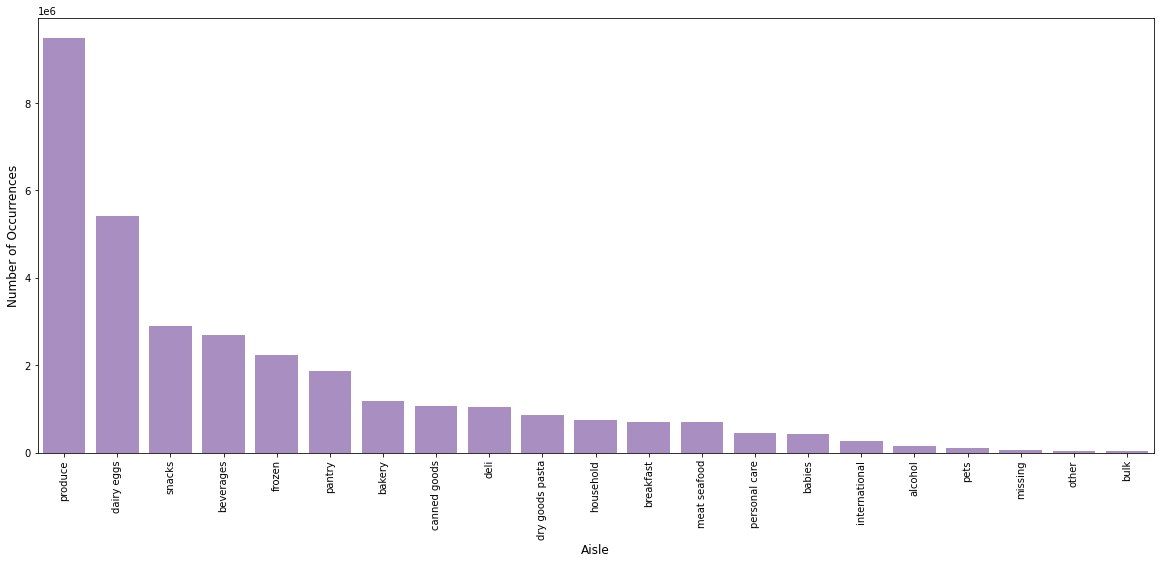

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[4])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

* The top two aisles are fresh fruits and fresh vegetables.! 
>- Top 10 Aisles
```
fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
```


#### b) aisles별 reorder ratio


In [ ]:
grouped_df = order_products_prior_df.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()
grouped_df.sort_values(by='reordered', ascending=False).reset_index().drop(labels='index', axis=1)

,aisle,reordered
0,milk,0.781428
1,water seltzer sparkling water,0.729593
2,fresh fruits,0.718104
3,eggs,0.705366
4,soy lactosefree,0.692551
...,...,...
129,beauty,0.212062
130,kitchen supplies,0.195377
131,first aid,0.194812
132,baking supplies decor,0.167229


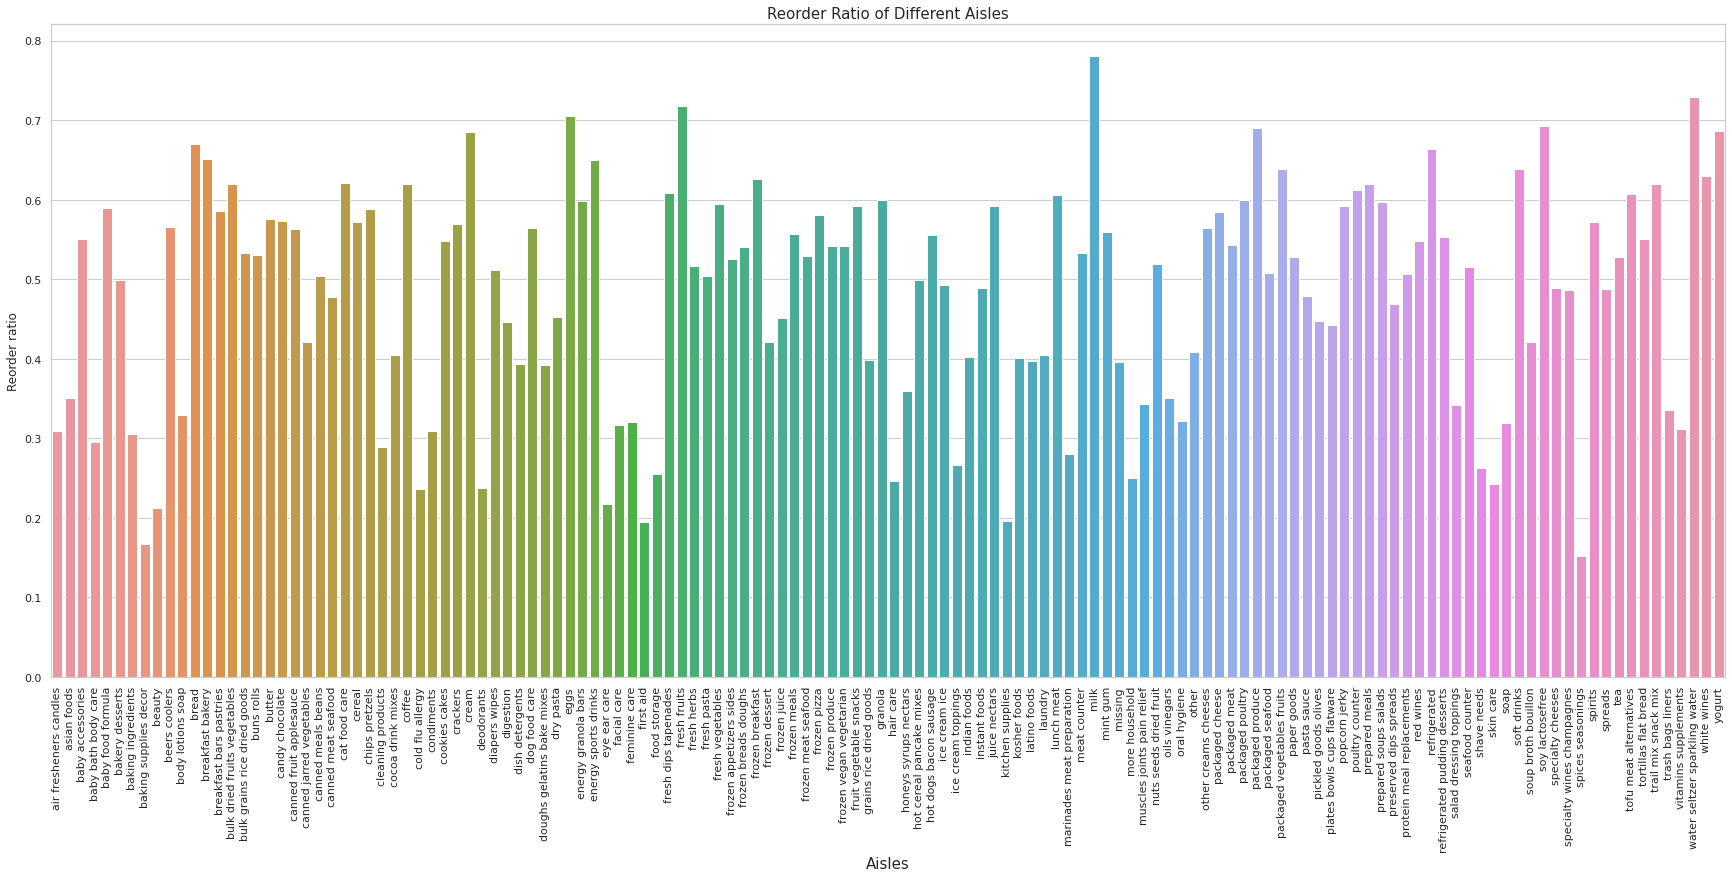

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(30,12))

# Plot the total crashes
sns.set_color_codes("pastel") # {deep, muted, pastel, dark, bright, colorblind}
sns.barplot(x=grouped_df['aisle'].values, y=grouped_df['reordered'].values)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Aisles', fontsize=15)
plt.title("Reorder Ratio of Different Aisles", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

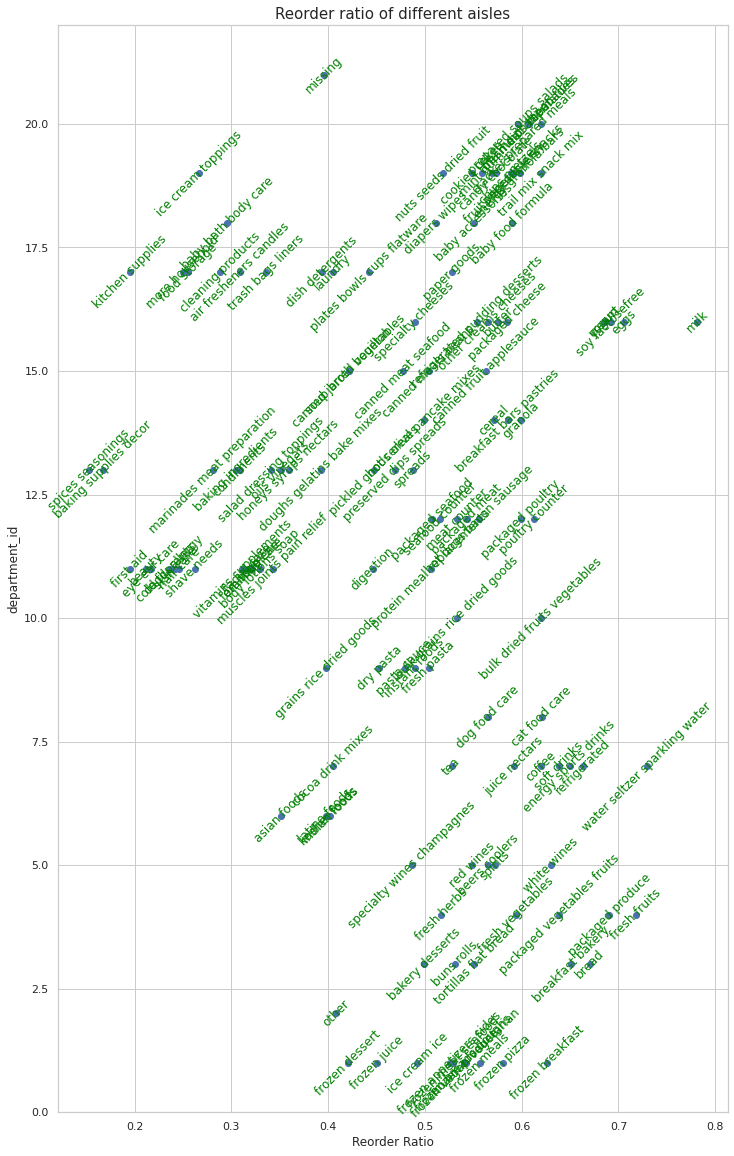

In [ ]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

#### c) Department 분포

* Let us now check the department wise distribution.

In [ ]:
cnt_srs = order_products_prior_df['department'].value_counts()
cnt_srs

produce            9479291
dairy eggs         5414016
snacks             2887550
beverages          2690129
frozen             2236432
pantry             1875577
bakery             1176787
canned goods       1068058
deli               1051249
dry goods pasta     866627
household           738666
breakfast           709569
meat seafood        708931
personal care       447123
babies              423802
international       269253
alcohol             153696
pets                 97724
missing              69145
other                36291
bulk                 34573
Name: department, dtype: int64

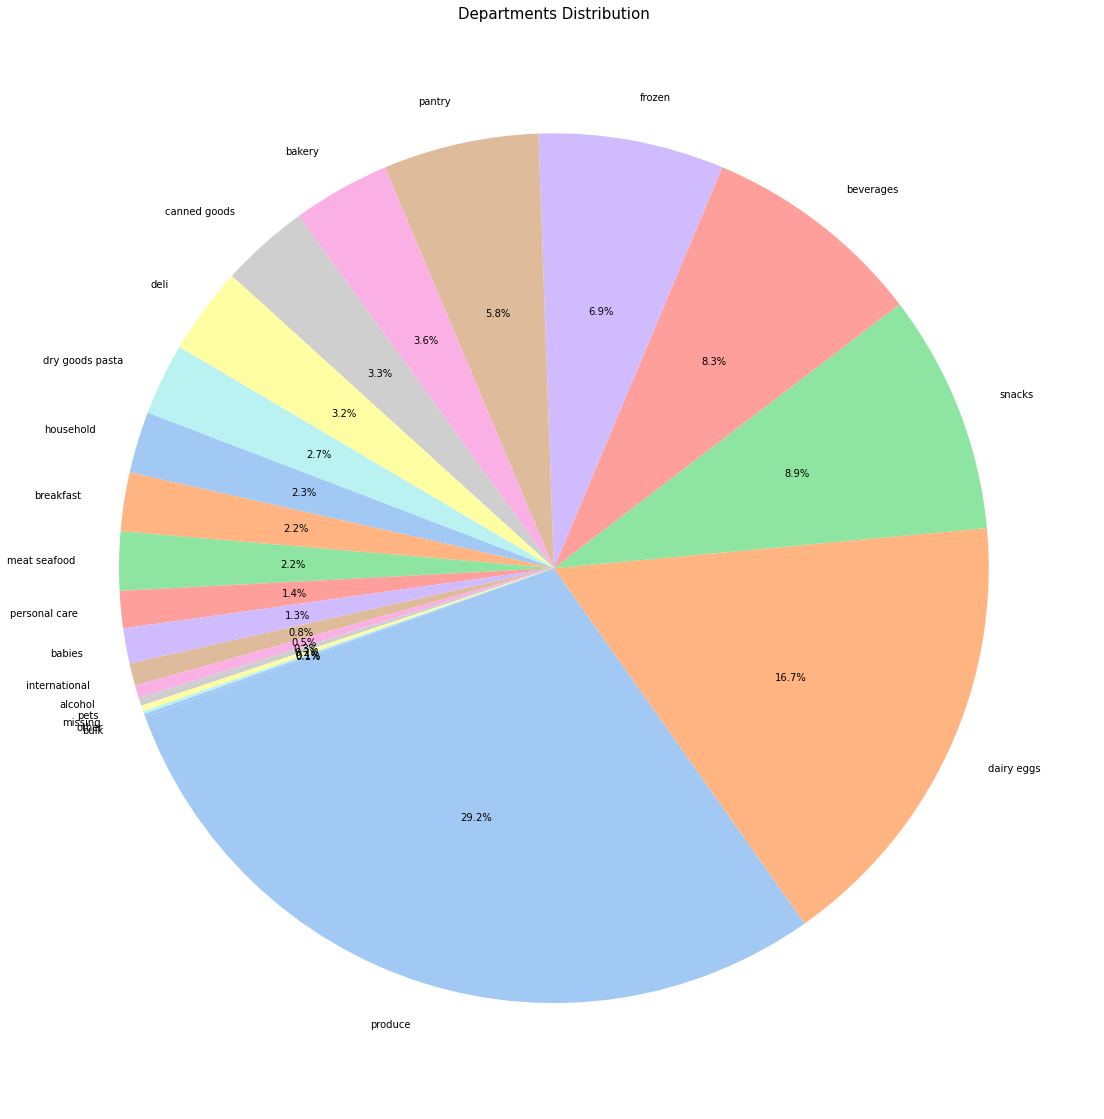

In [ ]:
data = (np.array((cnt_srs / cnt_srs.sum())*100))
labels = np.array(cnt_srs.index)

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:len(cnt_srs.index)]

#create pie chart
plt.figure(figsize=(20,20))
plt.pie(data, labels = labels, colors = colors, autopct='%1.1f%%', startangle=200)
plt.title("Departments Distribution", fontsize=15)
plt.show()

In [ ]:
for i in range(len(data)):
  print(f"{i+1:3d}위:\t{labels[i]:30.30s}\t{np.round(data[i], 1):0.1f}%")

  1위:	produce                       	29.2%
  2위:	dairy eggs                    	16.7%
  3위:	snacks                        	8.9%
  4위:	beverages                     	8.3%
  5위:	frozen                        	6.9%
  6위:	pantry                        	5.8%
  7위:	bakery                        	3.6%
  8위:	canned goods                  	3.3%
  9위:	deli                          	3.2%
 10위:	dry goods pasta               	2.7%
 11위:	household                     	2.3%
 12위:	breakfast                     	2.2%
 13위:	meat seafood                  	2.2%
 14위:	personal care                 	1.4%
 15위:	babies                        	1.3%
 16위:	international                 	0.8%
 17위:	alcohol                       	0.5%
 18위:	pets                          	0.3%
 19위:	missing                       	0.2%
 20위:	other                         	0.1%
 21위:	bulk                          	0.1%


* Produce is the largest department.
```
  1위:	produce                       	29.2%
  2위:	dairy eggs                    	16.7%
  3위:	snacks                        	8.9%
  4위:	beverages                     	8.3%
  5위:	frozen                        	6.9%
```


#### d) Department별 reorder ratio(부서별 재주문율)
* Now let us check the reordered percentage of each department. 

In [ ]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()
grouped_df.sort_values(by='reordered', ascending=False).reset_index().drop(labels='index', axis=1)

,department,reordered
0,dairy eggs,0.669969
1,beverages,0.653460
2,produce,0.649913
3,bakery,0.628141
4,deli,0.607719
5,pets,0.601285
6,babies,0.578971
7,bulk,0.577040
8,snacks,0.574180
9,alcohol,0.569924


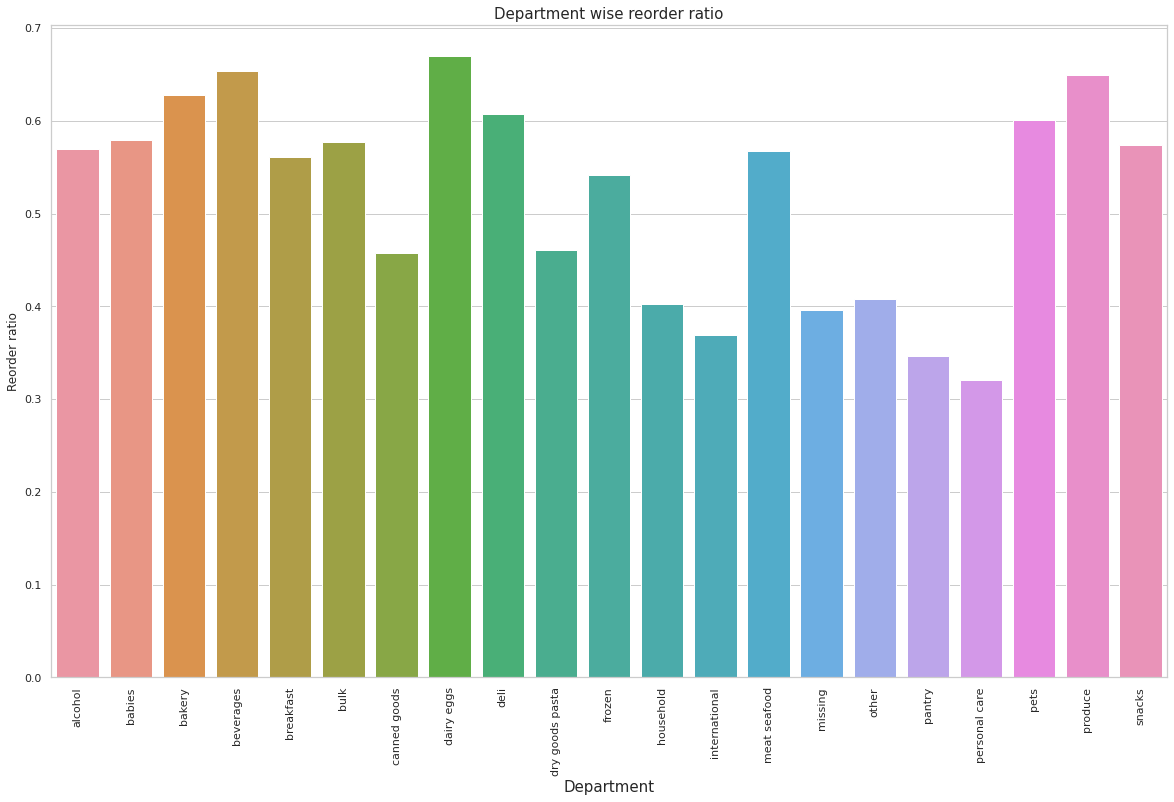

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(20,12))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x=grouped_df['department'].values, y=grouped_df['reordered'].values)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=15)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

* ```Personal care``` has lowest reorder ratio
* ```Dairy eggs``` have highest reorder ratio.
```
rank department	reordered
1	  dairy eggs   0.669969
2	  beverages	0.653460
3	  produce	  0.649913
4	  bakery	   0.628141
5	  deli	     0.607719
6	  pets	     0.601285
7	  babies	   0.578971
8	  bulk	     0.577040
9	  snacks	   0.574180
10	 alcohol	  0.569924


#### e) Add to Cart - Reorder ratio (장바구니 담은 순서 vs 재주문율)
* Let us now explore the relationship between how order of adding the product to the cart affects the reorder ratio.
>- 담은 순서가 70이상인 경우, 70으로 계산함

In [ ]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,add_to_cart_order_mod
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,1
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,2
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,3
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,4
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,5
...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household,6
32434485,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks,7
32434486,3421083,4600,8,0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen,8
32434487,3421083,24852,9,1,Banana,24,4,fresh fruits,produce,9


In [ ]:
order_products_prior_df["add_to_cart_order_mod"][order_products_prior_df["add_to_cart_order_mod"]>70] = 70
order_products_prior_df[order_products_prior_df["add_to_cart_order_mod"]==70]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,add_to_cart_order_mod
269199,28332,31737,70,0,Organic Freeze Dried Strawberries,117,19,nuts seeds dried fruit,snacks,70
269200,28332,27292,71,0,Sea Salt Macadamias,117,19,nuts seeds dried fruit,snacks,70
367612,38735,7503,70,0,Whole Almonds,117,19,nuts seeds dried fruit,snacks,70
367613,38735,812,71,0,Healthy Grains Oats & Honey Clusters with Toas...,57,14,granola,breakfast,70
367614,38735,25630,72,0,Healthy Grains Fiber Cinnamon Oat Clusters,57,14,granola,breakfast,70
...,...,...,...,...,...,...,...,...,...,...
32168942,3393151,20641,78,0,Pop Tarts Variety Pack,48,14,breakfast bars pastries,breakfast,70
32168943,3393151,38038,79,0,Layered Chewy Bars Double Chocolate Almond Nat...,100,21,missing,missing,70
32168944,3393151,17862,80,0,Minced Garlic,81,15,canned jarred vegetables,canned goods,70
32168945,3393151,43796,81,0,Sweet Peas & Butter Sauce Steamers,116,1,frozen produce,frozen,70


In [ ]:
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()
grouped_df

,add_to_cart_order_mod,reordered
0,1,0.677533
1,2,0.676251
2,3,0.658037
3,4,0.636958
4,5,0.617383
...,...,...
65,66,0.407002
66,67,0.397059
67,68,0.398352
68,69,0.393846


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


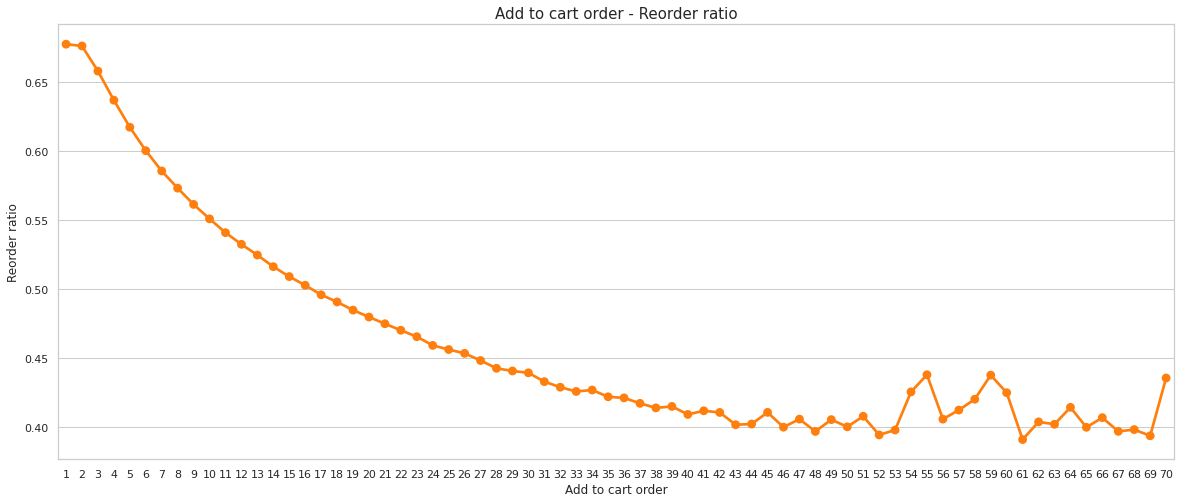

In [ ]:
plt.figure(figsize=(20,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[1])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.show()

* 초기에 장바구니에 담은 제품들을 재구매확률이 높았다.
>- 나중에 장바구니에 담은 제품은 비교적으로 재구매율이 낮았다.
>- This makes sense to me as well since we tend to first order all the products we used to buy frequently and then look out for the new products available. 


### 1.5. order_products_train.csv에 orders.csv파일 Merge하기

In [ ]:
 orders_df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

#### a) Reorder ratio by Time based variables (Time Feature로 분석한 재구매율) 

In [ ]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
order_products_train_df

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0
...,...,...,...,...,...,...,...,...,...,...
1384612,3421063,14233,3,1,169679,train,30,0,10,4.0
1384613,3421063,35548,4,1,169679,train,30,0,10,4.0
1384614,3421070,35951,1,1,139822,train,15,6,10,8.0
1384615,3421070,16953,2,1,139822,train,15,6,10,8.0


In [ ]:
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()
grouped_df

,order_dow,reordered
0,0,0.609624
1,1,0.598977
2,2,0.588365
3,3,0.586724
4,4,0.594632
5,5,0.606178
6,6,0.594238


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


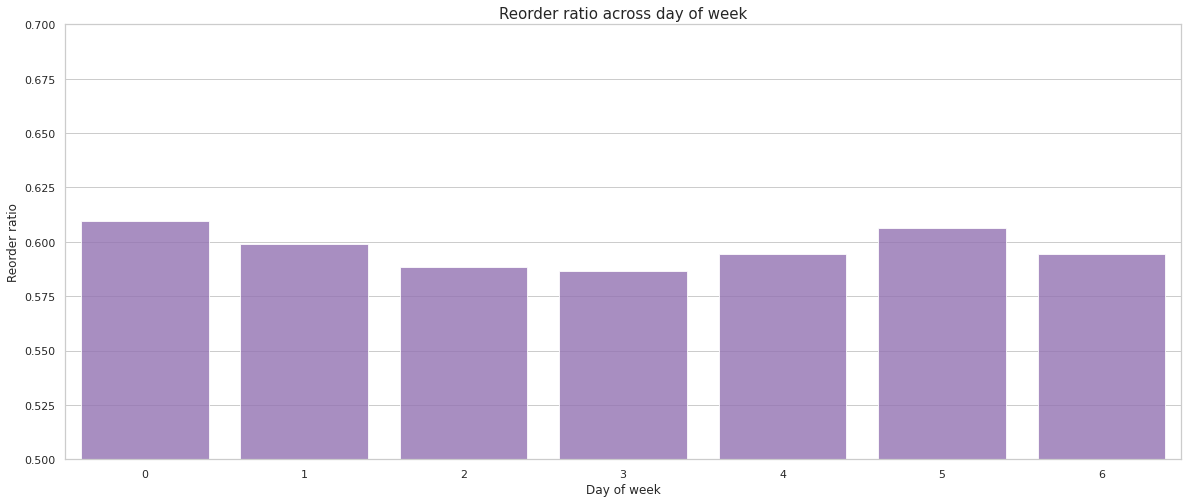

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.ylim(0.5, 0.7)
plt.show()

* 요일별 재주문율 분석 결과
>- 전체적으로 고르게 분포되었으며
>- 토 > 목 > 일 > 수 > 금 > 월 > 화 순이었다.
```
0 0.6096
1 0.599
2 0.5884
3 0.5867
4 0.5946
5 0.6062
6 0.5942
```

In [ ]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df

,order_hour_of_day,reordered
0,0,0.571177
1,1,0.579453
2,2,0.579665
3,3,0.581624
4,4,0.598108
5,5,0.622823
6,6,0.650629
7,7,0.649496
8,8,0.643353
9,9,0.623263


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


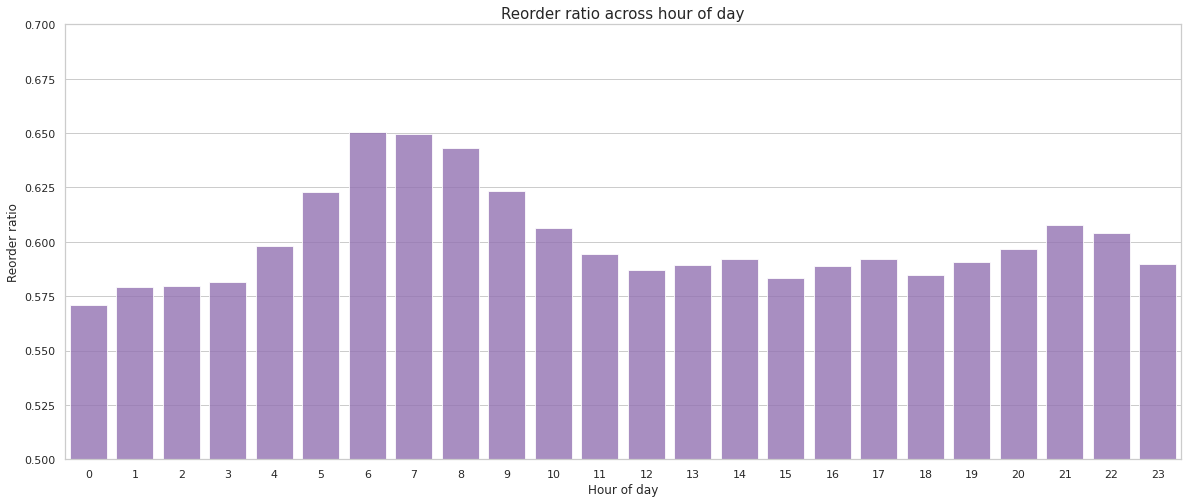

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.ylim(0.5, 0.7)
plt.show()

* 시간대별 재주문율 분석 결과
>- daytime (05시 ~ 09시)까지의 재주문율이 가장 높았고,
>- 저녁 퇴근 이후인 (19시부터 22시)까지 재주문율이 뒤를 이었다.

In [ ]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')
grouped_df

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
0,0.577806,0.587189,0.593341,0.553435,0.599455,0.607201,0.653686,0.677985,0.665738,0.635068,0.621011,0.598865,0.591088,0.594339,0.598129,0.591321,0.601673,0.614780,0.587774,0.609967,0.622931,0.641041,0.624711,0.605878
1,0.622407,0.550877,0.511111,0.664921,0.626016,0.597846,0.664765,0.656859,0.654519,0.642871,0.621910,0.595004,0.588104,0.597280,0.598679,0.570853,0.576848,0.572953,0.573926,0.603978,0.546328,0.602629,0.574086,0.586061
2,0.589645,0.621521,0.596045,0.567485,0.637427,0.629555,0.630402,0.639769,0.623237,0.604619,0.593306,0.591184,0.586465,0.577326,0.584259,0.586026,0.566976,0.577985,0.572924,0.588681,0.591452,0.575623,0.593591,0.567022
3,0.610324,0.507788,0.615730,0.553797,0.469101,0.638132,0.672999,0.624746,0.633493,0.621520,0.585475,0.595162,0.580602,0.581390,0.583432,0.572695,0.567665,0.570108,0.586399,0.560852,0.589400,0.579552,0.570420,0.573351
4,0.530852,0.575233,0.540659,0.593985,0.617761,0.666062,0.683973,0.635435,0.631235,0.592284,0.589687,0.575543,0.583605,0.585878,0.591776,0.593674,0.588828,0.606985,0.589294,0.594579,0.587502,0.609812,0.592511,0.591469
5,0.524818,0.582648,0.518617,0.562005,0.631579,0.610675,0.615789,0.639612,0.638711,0.631389,0.604936,0.609424,0.592033,0.605997,0.604482,0.596998,0.618176,0.596956,0.587063,0.589160,0.621550,0.588651,0.603620,0.593590
6,0.548270,0.613260,0.645455,0.619266,0.607629,0.614907,0.632563,0.657087,0.632832,0.615684,0.603210,0.588453,0.583145,0.577323,0.577603,0.569084,0.589777,0.592307,0.593773,0.577114,0.604114,0.618027,0.643312,0.594640


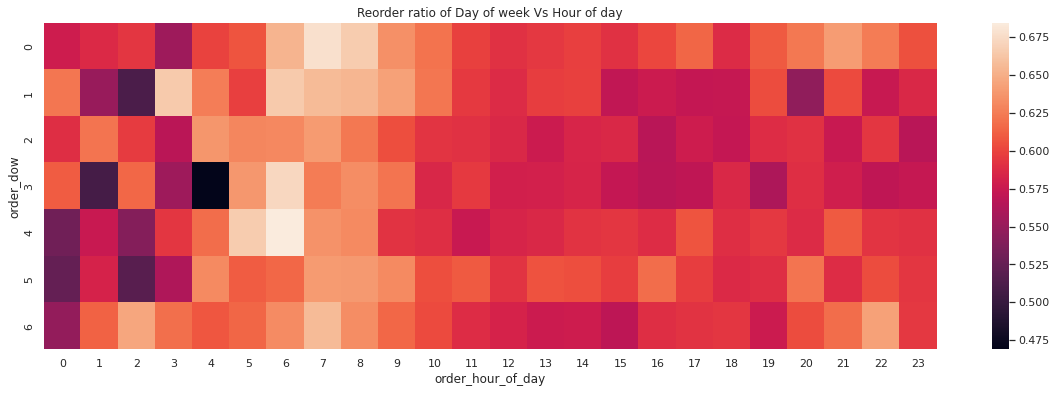

In [ ]:
plt.figure(figsize=(20,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

* 다른 시간대와 비교하여, 이른 아침에 재주문율이 높았다.